# Detecting Payment Fraud

In a 2016 study, it was estimated that credit card fraud was responsible for over 20 billion dollars in loss, worldwide. Accurately detecting cases of fraud is an ongoing area of research.

## Labeled Data¶
The payment fraud data set (Dal Pozzolo et al. 2015) was downloaded from Kaggle. This has features and labels for thousands of credit card transactions, each of which is labeled as fraudulent or valid. In this notebook, we'd like to train a model based on the features of these transactions so that we can predict risky or fraudulent transactions in the future.

* It is worth noticing that the column features V1-V28 are the relevant components after being processed and refined by PCA. Kaggle stated that they cannot disclose the features due to confidentiality issue. For such reason, we will work directly with the features without doing any further feature engineering. 

## Binary Classification
Since we have true labels to aim for, we'll take a supervised learning approach and train a binary classifier to sort data into one of our two transaction classes: fraudulent or valid. We'll train a model on training data and see how well it generalizes on some test data.

### The notebook will be broken down into 4 steps:

### 1) EDA

### 2) Train models

### 4) Parameters Tuning and PCA

###  5) Evaluating models

### Step 1: EDA

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# First, download all of the necessary libraries
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

In [3]:
# get the data
print((pd.__path__))
df = pd.read_csv('https://github.com/tramngo1603/Payment-Fraud-Detection/releases/download/1.0.0/creditcard.csv')
df.head()

['C:\\tools\\Anaconda3\\lib\\site-packages\\pandas']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df_features = df.loc[:, df.columns != "Class"]
df_target = df["Class"]

#### a. Check for missing values

In [6]:
df.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

It looks like there is no missing values in our dataset. 

#### b. Check for outliers through boxplots

In [7]:
df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


#### Plot a histogram of Time feature

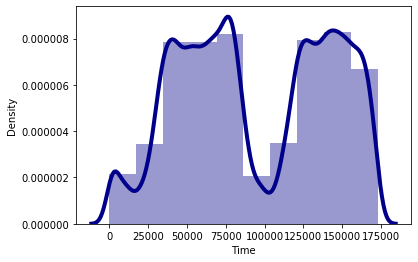

In [8]:
count,bin_edges = np.histogram(df['Time'])
sns.distplot(df['Time'], hist=True, kde=True, 
             bins=bin_edges, color = 'darkblue',
             kde_kws={'linewidth': 4})

### 2. Train models

#### a. Split Train-test

In [9]:
# First, randomly split the dataset into the training and testing sets.

features = df.columns.values
X = df[features[:-1]]
y = df[features[-1]]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=33)

In [10]:
print('Number of testing data: ',(len(X_test),len(y_test)))
print('Number of training data: ', (len(X_train),len(y_train)))

Number of testing data:  (56962, 56962)
Number of training data:  (227845, 227845)


#### b. Handle imbalanced classes

Number of fraudulent cases:  492
Number of non-fraudulent cases:  284315
Percentage of fraudulent cases in the dataset:  0.17 %


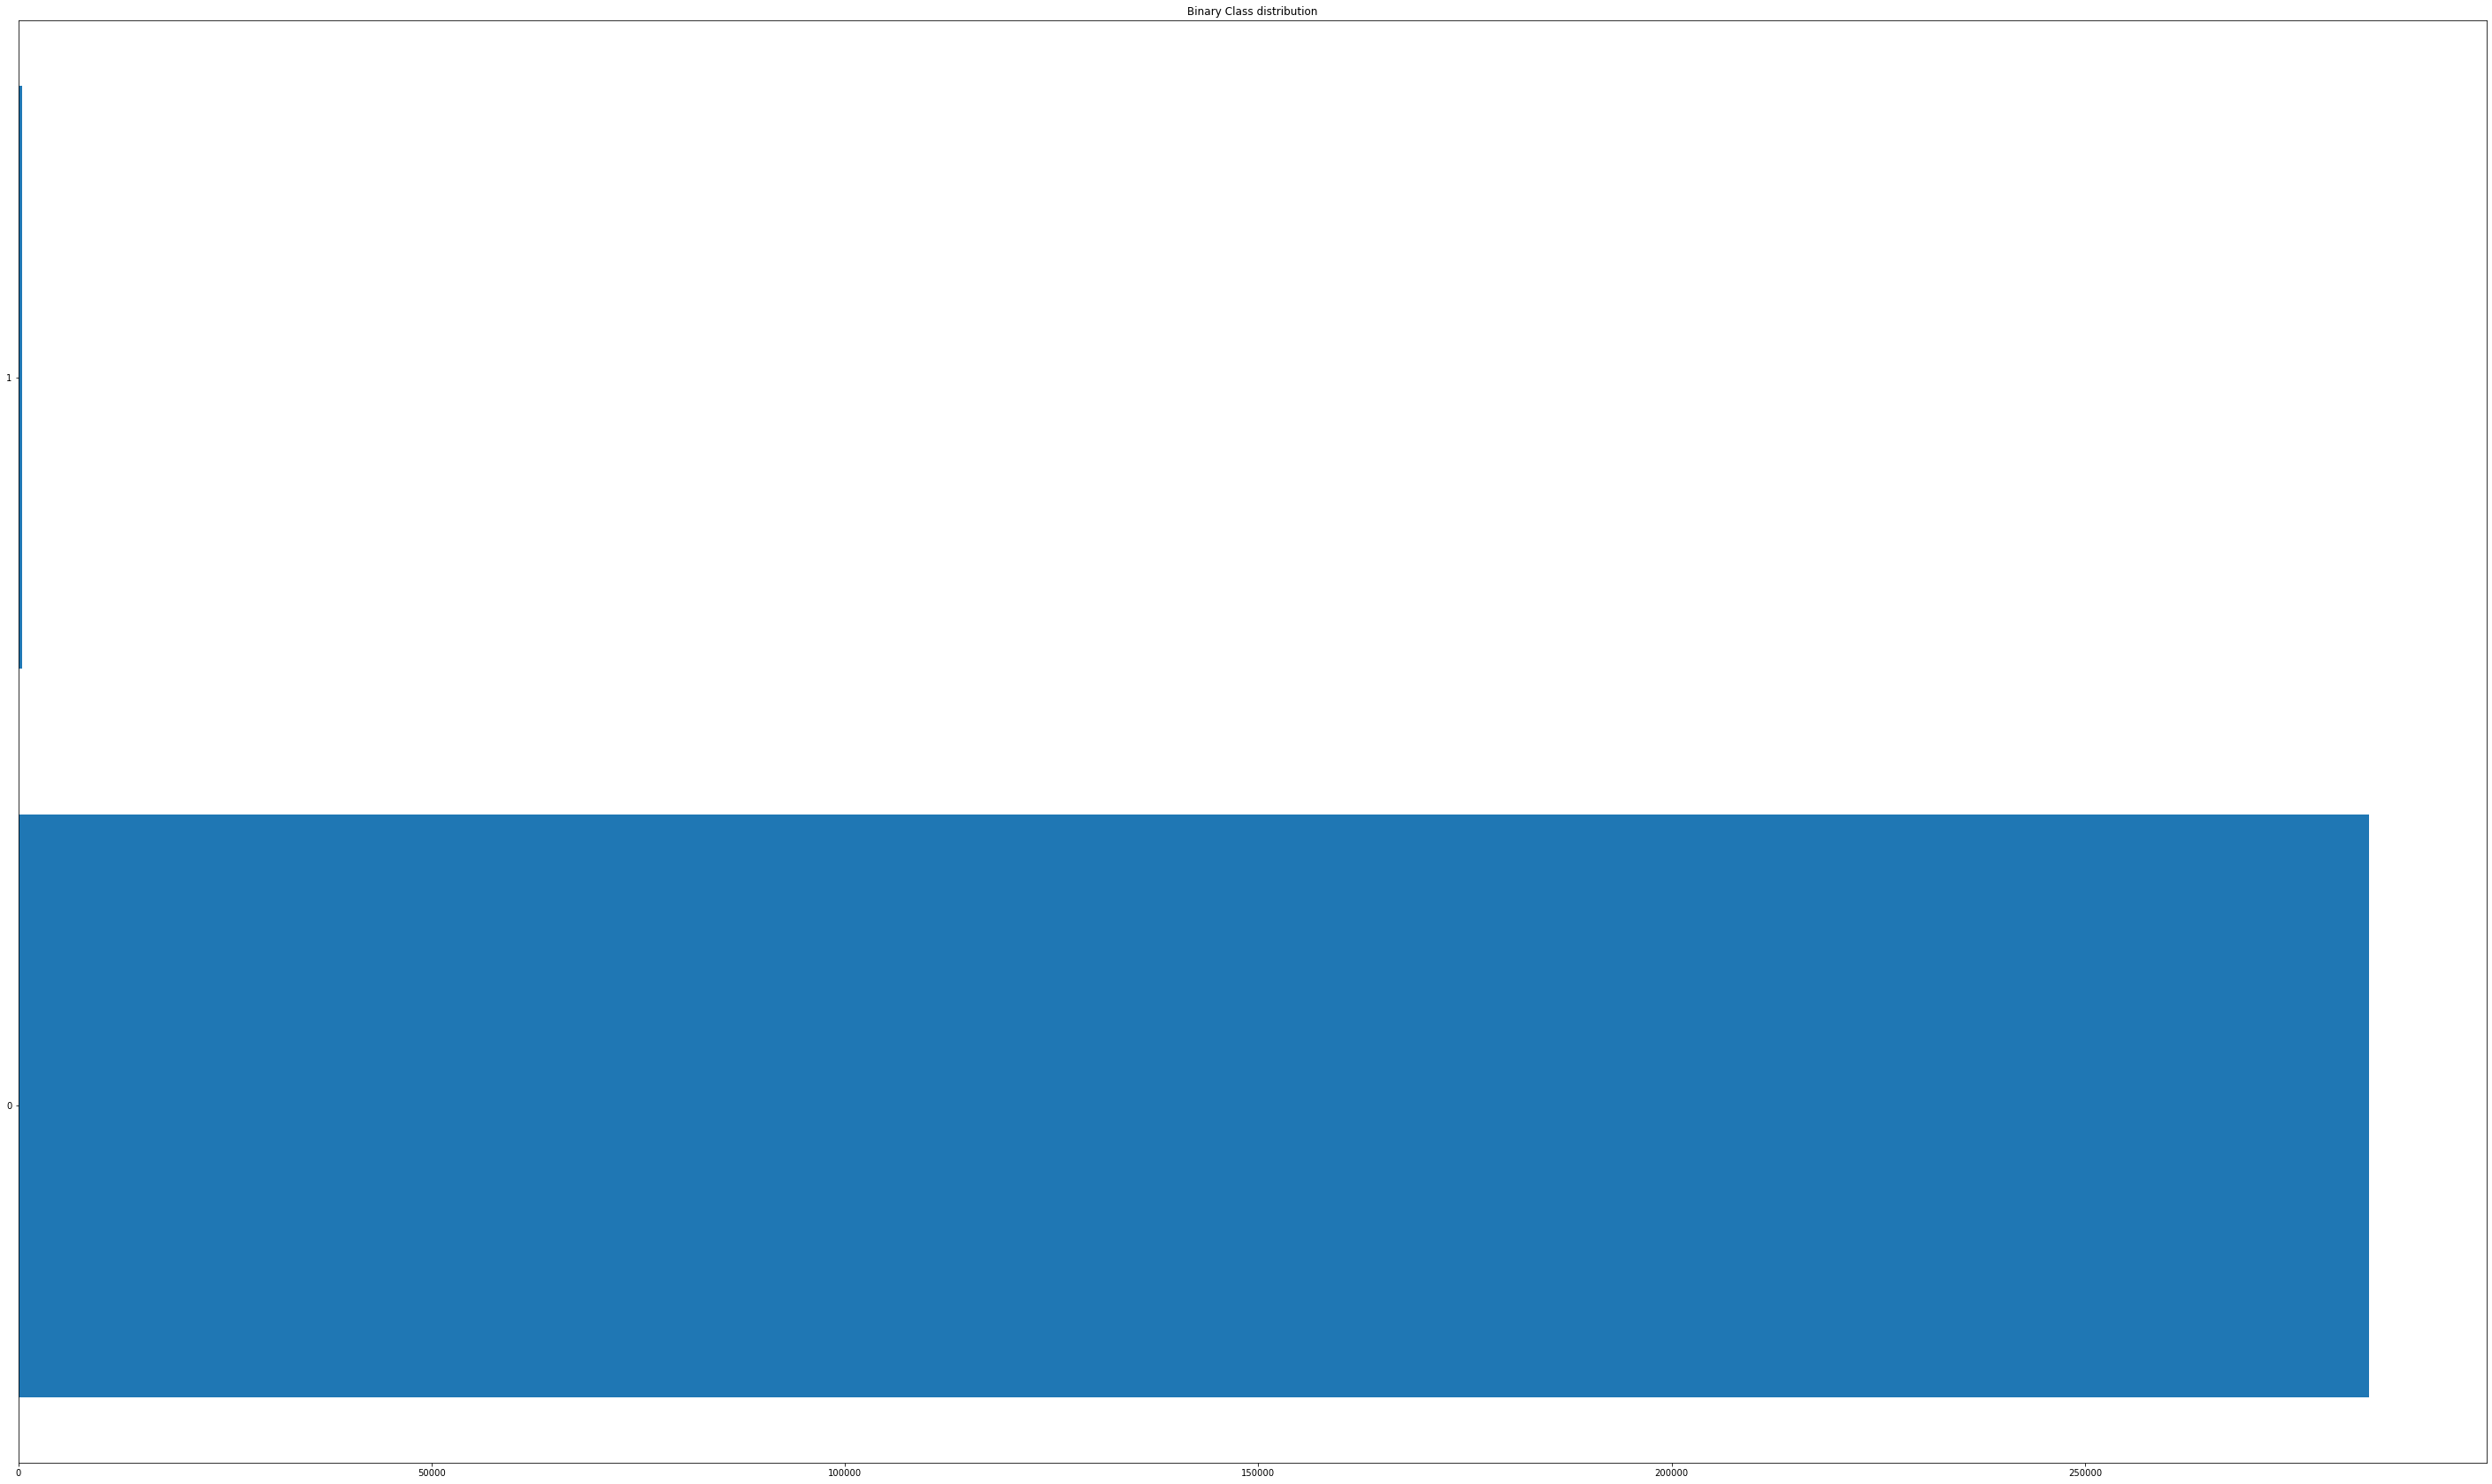

In [11]:
# show bar chart of class distribution
zero_class = df_target.value_counts()[0] 
one_class = df_target.value_counts()[1]

print("Number of fraudulent cases: ", one_class)
print("Number of non-fraudulent cases: ", zero_class)
print("Percentage of fraudulent cases in the dataset: ", "{:.2f}".format(one_class*100/(one_class+zero_class)), "%")

fig = plt.figure(figsize = (50, 30))
plt.barh(["0", "1"], [zero_class, one_class])
plt.title("Binary Class distribution")
plt.show()

#### We see that there is extreme class/label imbalance in this dataset. There are ways we can handle imbalanced dataset including:

#### 1. Oversampling/Downsampling
#### 2. SMOTE (Synthetic Minority Oversampling TEnichque)

Let us try the SMOTE method to re-sample our dataset. We are using the SMOTE method from a library `imblearn` to synthetically create samples from our minority class (class 1). 

### Data Modelling

***For the purpose of this project, we pick a model that produces binary classification prediction. I am going to try 3 supervised classification algorithms namely Logistics Regression, Naives Bayes Theorem, and Random Forest (based on CART). We will then evaluate them and pick the best one.***

#### 1) Naive Bayes Theorem

In [13]:
gnb=GaussianNB()

gnb.fit(X_train,y_train)
gnb_predicted_y = gnb.predict(X_test)

In [16]:
from sklearn.metrics import classification_report

print('Confusion Matrix for Naive Bayes: \n', confusion_matrix(y_test,gnb_predicted_y))
print('Accuracy Score: ',accuracy_score(y_test,gnb_predicted_y))
print("\n")
print('Classification report for Naive Bayes: \n', classification_report(y_test, gnb_predicted_y))

Confusion Matrix for Naive Bayes: 
 [[56486   373]
 [   39    64]]
Accuracy Score:  0.9927671078964924


Classification report for Naive Bayes: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56859
           1       0.15      0.62      0.24       103

    accuracy                           0.99     56962
   macro avg       0.57      0.81      0.62     56962
weighted avg       1.00      0.99      0.99     56962



We see that we miscalculated 412 out of 56,962 predictions. This gives us an accuracy score of 99.27%, which should look impressive, but this is not believable as it looks. Let's analyze the classification report:

#### Precision – What percent of your predictions were correct?
Here, our model can predict 100% of the class 0, but only about 15% of class 1. 

#### Recall – What percent of the positive cases did we catch? 
Here, for all the 0 class records, we correctly labelled about 99% of the time. For 1-class records, we correctly labelled about 62%.  

#### F1 score the the weighted average of Precision and Recall. 
Our F1 score for the 0 class is perfect, at 1. However, our F1 score for the 1 class is quite low, at 0.24, indicating that the model is not good yet in predicting the 1 class labels. 

#### 2) Logistic Regression

In [17]:
lgr=LogisticRegression()

lgr.fit(X_train,y_train)
lgr_predicted_y = lgr.predict(X_test)

In [18]:
print(lgr.predict_proba(X_test[:10]))

[[9.99999435e-01 5.64672542e-07]
 [9.99999915e-01 8.50570343e-08]
 [9.99999086e-01 9.13623584e-07]
 [9.99999970e-01 2.98935874e-08]
 [9.99999776e-01 2.23672979e-07]
 [9.95743577e-01 4.25642259e-03]
 [9.99999971e-01 2.87141345e-08]
 [9.99999881e-01 1.19309802e-07]
 [1.00000000e+00 4.01633894e-15]
 [9.99999730e-01 2.69529248e-07]]


In [24]:
print('Confusion Matrix for Logistic Regression: \n', confusion_matrix(y_test,lgr_predicted_y))
print('Accuracy Score: ',accuracy_score(y_test,lgr_predicted_y))
print("\n")
print('Classification report for Logistic Regression: \n', classification_report(y_test, lgr_predicted_y))

Confusion Matrix for Logistic Regression: 
 [[56817    42]
 [   30    73]]
Accuracy Score:  0.998735999438222


Classification report for Logistic Regression: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.63      0.71      0.67       103

    accuracy                           1.00     56962
   macro avg       0.82      0.85      0.83     56962
weighted avg       1.00      1.00      1.00     56962



#### 3) Random Forest 

In [22]:
clf = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0) 
                            # we set n_estimators (number of trees) to be 200.
clf.fit(X_train,y_train)
clf_predicted_y = clf.predict(X_test)

In [23]:
print('Confusion Matrix for Random Forest: \n', confusion_matrix(y_test,clf_predicted_y))
print('Accuracy Score: ',accuracy_score(y_test,clf_predicted_y))
print("\n")
print('Classification report for Naive Bayes: \n', classification_report(y_test, gnb_predicted_y))

Confusion Matrix for Random Forest: 
 [[56851     8]
 [   37    66]]
Accuracy Score:  0.9992099996488887


Classification report for Naive Bayes: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56859
           1       0.15      0.62      0.24       103

    accuracy                           0.99     56962
   macro avg       0.57      0.81      0.62     56962
weighted avg       1.00      0.99      0.99     56962



### Step 3: Feature Selection with PCA

### Step 4: Evaluate models 